In [ ]:
!pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9 MB 19 kB/s 
     |████████████████████████████████| 4.0 MB 20.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.4.0+cu100 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.4.0+cu100 which

In [ ]:
!pip install robustness

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 3.4 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 125 kB 17.7 MB/s 
     |████████████████████████████████| 182 kB 68.2 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=012de946ad027991ba7ce071748c50ae1646a57b4da568959df6f069cec23dfd
  Stored in directory: /root/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built GPUtil


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive')

Mounted at /content/drive


In [ ]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.nn.functional import interpolate
import numpy as np
import matplotlib.pyplot as plt
from robustness import datasets, cifar_models
import attacker, utils

In [ ]:
HPARAMS = {
  "BATCH_SIZE" : 10,
  "NUM_WORKERS": 1,
  "DATA_AUG": False
}

In [ ]:
image_dim = 32
classes = {-1: 'noise',
 0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}
device = torch.device("cuda")

In [ ]:
dataset = datasets.CIFAR('/data/')
_, test_loader = dataset.make_loaders(workers= HPARAMS["NUM_WORKERS"], 
                                      batch_size=HPARAMS["BATCH_SIZE"], 
                                      data_aug=HPARAMS["DATA_AUG"])
data_iterator = enumerate(test_loader)

==> Preparing dataset cifar..


0it [00:00, ?it/s]

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to /data/cifar-10-python.tar.gz


0it [00:00, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data/
Files already downloaded and verified


In [ ]:
clf = cifar_models.ResNet50(num_classes = 10)
atk = attacker.AttackerModel(clf, dataset)

In [ ]:
model = utils.load_model(atk=atk, pt_file="./drive/MyDrive/CIFAR.pt")
model = model.to(device)
model.eval()
pass

Loading checkpoint
Loaded checkpoint at epoch 153


In [ ]:
def plot_all_samples(concat_samples, row_titles, r = 3, c = 10, figsize = (25, 7.5), fontsize = 24, tick_marks = False):
  fig, ax = plt.subplots(r, c, figsize=figsize)

  #For each image
  for i in range(3):
    #For each example
    ax[i][0].set_ylabel(row_titles[i], fontsize=fontsize)

    for j in range(len(concat_samples[0])):
      ax_ij = ax[i][j]
      
      current_sample = np.array(concat_samples[i][j])
      #Reshape for imshow
      sample_for_imshow = np.moveaxis(current_sample, source = [0, 1, 2], destination = [-1, -3, -2])
      ax_ij.imshow(sample_for_imshow)

  if not tick_marks:
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

  plt.show()

In [ ]:
_, (image, target) = next(data_iterator)
downsampled = interpolate(image,(16,16),mode='bilinear')
lowres = interpolate(downsampled,(32,32),mode='nearest')
_, superres = model(lowres.to(device), target.to(device), eps=5,step_size=1,iters=10,normalize=True)

In [ ]:
concatenated_samples = [image.cpu(), lowres, superres.cpu()]
row_titles = ["Original", "Low Res","Super Res"]

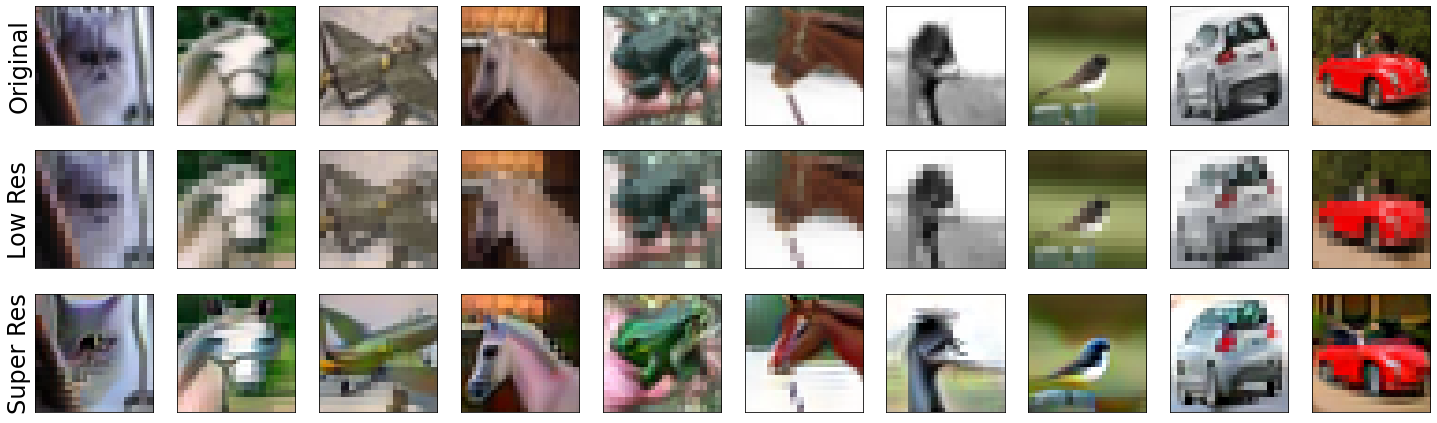

In [ ]:
utils.plot_all_samples(concatenated_samples, row_titles,r=3)